In [90]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import nltk
from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc

In [2]:
# Download required NLTK data 
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
DATA_PATH_TRAIN = '../data/raw/train.csv'
DATA_PATH_TEST  = '../data/raw/test.csv'

# Helper functions

In [28]:
def clean_text(text):
    """
    Basic text cleaning:
    1. Converting strings to lowercase
    2. Removing non-word and non-whitespace characters
    3. Removing digits
    """   
    # Converting to lowercase
    text = text.lower()
    
    # Removing non-word and non-whitespace characters
    text = re.sub(r'[^\w\s]', '', text)
    
    # Removing digits
    text = re.sub(r'\d', '', text)
    
    return text

In [6]:
def tokenize_text(text):
    """Tokenize text"""
    return word_tokenize(text)
    
def remove_stopwords(tokens):
    """Remove stopwords"""
    stop_words = set(stopwords.words('english'))
    return [token for token in tokens if token not in stop_words]
    
def stem_tokens(tokens):
    """Apply stemming"""
    stemmer = SnowballStemmer('english')
    return [stemmer.stem(token) for token in tokens]
    
def lemmatize_tokens(tokens):
    """Apply lemmatization"""
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

In [34]:
def preprocess_text(text, use_stemming, use_lemmatization):
    """Complete text preprocessing pipeline"""
    # Clean text
    cleaned = clean_text(text)
        
    # Tokenize
    tokens = tokenize_text(cleaned)
        
    # Remove stopwords
    tokens = remove_stopwords(tokens)
        
    # Apply stemming or lemmatization
    if use_stemming:
        tokens = stem_tokens(tokens)
    elif use_lemmatization:
        tokens = lemmatize_tokens(tokens)
        
    return ' '.join(tokens)

In [73]:
def predict_cls(model, X):
  return model.predict(X)

def evaluate_cls_model(model, X, y, name, return_metrics = False):
    y_pred = predict_cls(model, X)

    # Confusion Matrix
    cm         = confusion_matrix(y, y_pred)
    cm_counts  = confusion_matrix(y, y_pred)  # Raw counts for percentages
    total      = cm_counts.sum()
    cm_percent = (cm_counts / total * 100).round(2)  # Percentage for each cell

    # Calculate metrics
    accuracy  = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall    = recall_score(y, y_pred)
    f1        = f1_score(y, y_pred)

    # Create custom annotations with true values and percentages
    annot = [[f'{cm[i,j]}\n({cm_percent[i,j]:.2f}%)' for j in range(cm.shape[1])] for i in range(cm.shape[0])]

    plt.figure(figsize = (10, 4))

    # Confusion Matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot = annot, fmt = '', cmap = 'Blues', cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix \n{name}')

    # ROC Curve and AUC
    if hasattr(model, 'predict_proba'):
      y_pred_proba         = model.predict_proba(X)[:, 1]
      fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
      roc_auc              = auc(fpr, tpr)

      plt.subplot(1, 2, 2)
      plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = f'ROC curve (area = {roc_auc:.2f})')
      plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title(f'ROC Curve for {name}')
      plt.legend(loc = "lower right")
    else:
        plt.text(0.5, 0.5, 'ROC curve not available\nfor this model', 
                ha='center', va='center', fontsize=12)
        plt.title(f'ROC Curve\n{name}')
    plt.show()

    print(f"\n{name} Results:")
    print("=" * 50)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    if hasattr(model, 'predict_proba'):
        print(f"ROC-AUC:   {roc_auc:.4f}")

    # Full classification report
    print('\nClassification Report:\n', classification_report(y, y_pred))

    if return_metrics:
        metrics_dict = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc if hasattr(model, 'predict_proba') else None
        }
        return metrics_dict

# Read data

In [9]:
df_train = pd.read_csv(DATA_PATH_TRAIN)
df_test  = pd.read_csv(DATA_PATH_TEST)

In [10]:
display(df_train.head(), df_test.head())

,review,sentiment
0,I caught this little gem totally by accident b...,positive
1,I can't believe that I let myself into this mo...,negative
2,*spoiler alert!* it just gets to me the nerve ...,negative
3,If there's one thing I've learnt from watching...,negative
4,"I remember when this was in theaters, reviews ...",negative


,review,sentiment
0,"Yes, MTV there really is a way to market Daria...",negative
1,The story of the bride fair is an amusing and ...,negative
2,"A team varied between Scully and Mulder, two o...",positive
3,This was a popular movie probably because of t...,negative
4,This movie made me so angry!! Here I am thinki...,negative


# EDA

In [11]:
df_train.shape, df_test.shape

((40000, 2), (10000, 2))

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     40000 non-null  object
 1   sentiment  40000 non-null  object
dtypes: object(2)
memory usage: 625.1+ KB


In [13]:
df_train.sentiment.unique()

array(['positive', 'negative'], dtype=object)

In [14]:
df_train.sentiment.value_counts()

sentiment
positive    20000
negative    20000
Name: count, dtype: int64

In [15]:
df_test.sentiment.value_counts()

sentiment
negative    5000
positive    5000
Name: count, dtype: int64

## Check for duplicates

In [16]:
duplicated_df_train = df_train[df_train.duplicated()]
duplicated_df_test  = df_test[df_test.duplicated()]
display(duplicated_df_train.shape, duplicated_df_train, duplicated_df_test.shape, duplicated_df_test)

(272, 2)

,review,sentiment
1700,There are plenty of comments already posted sa...,negative
2062,No one would ever question that director Leos ...,positive
2659,Well I guess I know the answer to that questio...,negative
3540,There's something frustrating about watching a...,negative
4176,Do we really need any more narcissistic garbag...,negative
...,...,...
39722,"Yep, this has got to be one of the lamest movi...",negative
39738,Inappropriate. The PG rating that this movie g...,negative
39803,"Les Visiteurs, the first movie about the medie...",negative
39926,This film is so bad and gets worse in every im...,negative


(13, 2)

,review,sentiment
1899,The scenes are fast-paced. the characters are ...,positive
2964,I've tried to reconcile why so many bad review...,positive
3068,What a clunker!<br /><br />It MUST have been m...,negative
3266,The daytime TV of films. Seldom have I felt so...,negative
4624,"Pretentious claptrap, updating Herman Melville...",negative
6026,"well, the writing was very sloppy, the directi...",negative
6990,"Hilarious, clean, light-hearted, and quote-wor...",positive
7524,What can I say? An excellent end to an excelle...,positive
8167,"What a shocker. For starters, I couldn't stand...",negative
8911,Since I am required to write minimum of 10 lin...,negative


There are some duplicates in train and test data, I'll delete them.

In [17]:
df_train = df_train.drop_duplicates()
df_test  = df_test.drop_duplicates()

In [18]:
df_train.shape, df_test.shape

((39728, 2), (9987, 2))

## Check missing values

In [19]:
df_train.isna().sum()

review       0
sentiment    0
dtype: int64

In [20]:
df_test.isna().sum()

review       0
sentiment    0
dtype: int64

There are no missing values in both sets.

## Sentiment Distribution Analysis

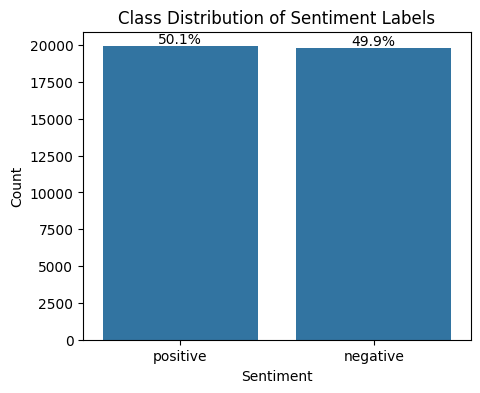

In [21]:
# Plotting the sentiment distribution

plt.figure(figsize = (5, 4))
ax = sns.countplot(x = 'sentiment', data = df_train, order = df_train['sentiment'].value_counts().index)
plt.title('Class Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')

total = len(df_train)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage,
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha = 'center', va = 'bottom')
plt.show()

 The dataset contains an almost equal distribution between positive and negative sentiments.

In [22]:
# Displaying class distribution and summary of text length

df_train['text_length'] = df_train['review'].apply(len)
display(df_train['sentiment'].value_counts(), df_train['text_length'].describe())

sentiment
positive    19923
negative    19805
Name: count, dtype: int64

count    39728.000000
mean      1311.359469
std        988.798970
min         41.000000
25%        699.000000
50%        971.500000
75%       1596.000000
max      13704.000000
Name: text_length, dtype: float64

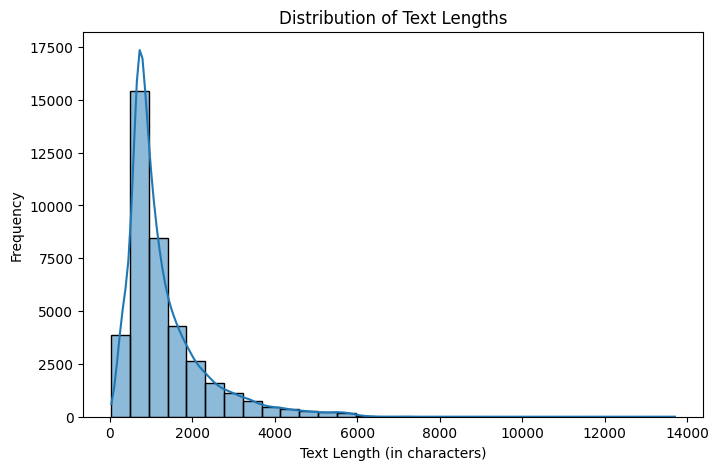

In [23]:
# Plotting the distribution of text lengths

plt.figure(figsize = (8, 5))
sns.histplot(df_train['text_length'], bins = 30, kde = True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length (in characters)')
plt.ylabel('Frequency')
plt.show()

Most texts fall within the range of 700 to 1500 characters, with the average length being 1311 characters.

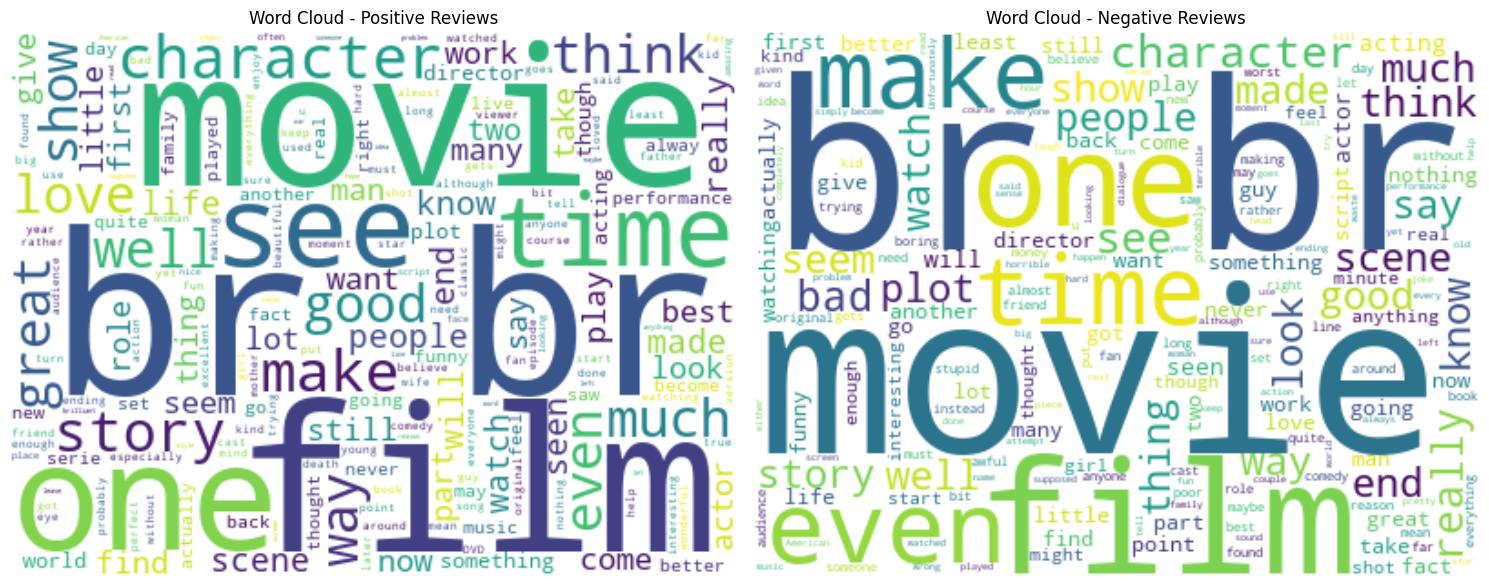

In [24]:
#Word clouds
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
positive_reviews = df_train[df_train['sentiment'] == 'positive']['review']
positive_text = ' '.join(positive_reviews)
wordcloud_pos = WordCloud(width=400, height=300, background_color='white').generate(positive_text)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Word Cloud - Positive Reviews')
plt.axis('off')

plt.subplot(1, 2, 2)
negative_reviews = df_test[df_test['sentiment'] == 'negative']['review']
negative_text = ' '.join(negative_reviews)
wordcloud_neg = WordCloud(width=400, height=300, background_color='white').generate(negative_text)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Word Cloud - Negative Reviews')
plt.axis('off')

plt.tight_layout()
plt.show()


**Summary of Key Insights:**

1. Sentiment Class Distribution:
  - There are almost the same number of positive and negative labels.
2. Text Length Distribution:
  - The average length of texts is about 1311 characters.
  - The most common text lengths range between 700 and 1500 characters, with a drop off towards the end of the distribution.
  - The maximum length of texts in the data set is 13704 characters.

In [25]:
df_train.drop('text_length', axis = 1, inplace = True)

# Data Processing

In [26]:
df_train

,review,sentiment
0,I caught this little gem totally by accident b...,positive
1,I can't believe that I let myself into this mo...,negative
2,*spoiler alert!* it just gets to me the nerve ...,negative
3,If there's one thing I've learnt from watching...,negative
4,"I remember when this was in theaters, reviews ...",negative
...,...,...
39995,It's the 1920s. And a man named Walt Disney wa...,positive
39996,"The first (and only) time I saw ""Shades"" was d...",negative
39997,This was such a waste of time. Danger: If you ...,negative
39998,this is by far the most pathetic movie Indian ...,negative


## Compare stemming vs lemmatization

In [30]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

# Compare stemming vs lemmatization
print("Comparison of Stemming vs Lemmatization:")

# Test preprocessing on sample text
sample_text = df_train['review'].iloc[0]
print(f"\nOriginal text: {sample_text[:200]}...")

# Step by step preprocessing
cleaned_text = clean_text(sample_text)
print(f"\nCleaned text: {cleaned_text[:200]}...")

tokens = tokenize_text(cleaned_text)
print(f"\nTokenized (first 20): {tokens[:20]}")

tokens_no_stop = remove_stopwords(tokens)
print(f"\nWithout stopwords (first 20): {tokens_no_stop[:20]}")

stemmed_tokens = stem_tokens(tokens_no_stop)
print(f"\nStemmed (first 20): {stemmed_tokens[:20]}")

lemmatized_tokens = lemmatize_tokens(tokens_no_stop)
print(f"\nLemmatized (first 20): {lemmatized_tokens[:20]}")


Comparison of Stemming vs Lemmatization:

Original text: I caught this little gem totally by accident back in 1980 or '81. I was at a revival theatre to see two old silly sci-fi movies. The theatre was packed full and (with no warning) they showed a bunch o...

Cleaned text: i caught this little gem totally by accident back in  or  i was at a revival theatre to see two old silly scifi movies the theatre was packed full and with no warning they showed a bunch of scifi shor...

Tokenized (first 20): ['i', 'caught', 'this', 'little', 'gem', 'totally', 'by', 'accident', 'back', 'in', 'or', 'i', 'was', 'at', 'a', 'revival', 'theatre', 'to', 'see', 'two']

Without stopwords (first 20): ['caught', 'little', 'gem', 'totally', 'accident', 'back', 'revival', 'theatre', 'see', 'two', 'old', 'silly', 'scifi', 'movies', 'theatre', 'packed', 'full', 'warning', 'showed', 'bunch']

Stemmed (first 20): ['caught', 'littl', 'gem', 'total', 'accid', 'back', 'reviv', 'theatr', 'see', 'two', 'old', 'silli',

Stemming is a simple and practical approach that involves cutting off the ends of words with the intention of obtaining the correct root form.
Lemmatization aims to remove inflectional endings only and to return the base or dictionary form of a word, which is known as 'lemma'. 

## Basic processing

In [35]:
# Create copies for different preprocessing approaches
train_stemmed    = df_train.copy()
train_lemmatized = df_train.copy()

train_stemmed['processed_review']    = [preprocess_text(text, use_stemming = True, use_lemmatization = False) for text in train_stemmed['review']]
train_lemmatized['processed_review'] = [preprocess_text(text, use_stemming = False, use_lemmatization = True) for text in train_lemmatized['review']]

In [41]:
# Compare processing results
print("\nComparison of preprocessing approaches:")
sample_idx = 11
print(f"Original: {df_train['review'].iloc[sample_idx][:500]}...")
print(f"Stemmed: {train_stemmed['processed_review'].iloc[sample_idx][:500]}...")
print(f"Lemmatized: {train_lemmatized['processed_review'].iloc[sample_idx][:500]}...")


Comparison of preprocessing approaches:
Original: Because 'cruel' would be the only word in existence to describe the intentions of these film makers. Where do you even begin? In a spout of b*tchiness, I'm going to start with the awful acting of nearly everybody in this movie. Scratch that. Nearly does not belong in that sentence. I can't think of even one character who was portrayed well. Although, in all fairness, it would be nearly impossible to portray these zero dimensional characters in a successful way. Still, the girl who played Katheri...
Stemmed: cruel would word exist describ intent film maker even begin spout btchiness im go start aw act near everybodi movi scratch near belong sentenc cant think even one charact portray well although fair would near imposs portray zero dimension charact success way still girl play katherin whose name purpos dont includ im pretend doesnt exist remain one worst actor ive ever seen eclips guy play sebastian stori god aw attempt mirror brillia

In [43]:
display(train_stemmed.head(5), train_lemmatized.head(5))

,review,sentiment,processed_review
0,I caught this little gem totally by accident b...,positive,caught littl gem total accid back reviv theatr...
1,I can't believe that I let myself into this mo...,negative,cant believ let movi accomplish favor friend a...
2,*spoiler alert!* it just gets to me the nerve ...,negative,spoiler alert get nerv peopl remak use term lo...
3,If there's one thing I've learnt from watching...,negative,there one thing ive learnt watch georg romero ...
4,"I remember when this was in theaters, reviews ...",negative,rememb theater review said horribl well didnt ...


,review,sentiment,processed_review
0,I caught this little gem totally by accident b...,positive,caught little gem totally accident back reviva...
1,I can't believe that I let myself into this mo...,negative,cant believe let movie accomplish favor friend...
2,*spoiler alert!* it just gets to me the nerve ...,negative,spoiler alert get nerve people remake use term...
3,If there's one thing I've learnt from watching...,negative,there one thing ive learnt watching george rom...
4,"I remember when this was in theaters, reviews ...",negative,remember theater review said horrible well did...


## Vectorization

In [48]:
# Prepare data for vectorization
X_text_stemmed    = train_stemmed['processed_review']
X_text_lemmatized = train_lemmatized['processed_review']
y = df_train['sentiment']

# Encode labels
encoder   = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Split data for evaluation
X_train_stem, X_val_stem, y_train, y_val = train_test_split(X_text_stemmed, y_encoded, test_size = 0.2, random_state = 42, stratify = y_encoded)
X_train_lem, X_val_lem, _, _ = train_test_split(X_text_lemmatized, y_encoded, test_size = 0.2, random_state = 42, stratify = y_encoded)

### Bag of Words (BoW) vs Term Frequency-Inverse Document Frequency (TF-IDF)

The Bag of Words model represents text by converting it into a collection of words (or tokens) and their frequencies, disregarding grammar, word order, and context. Each document is represented as a vector of word counts, with each element in the vector corresponding to the frequency of a specific word in the document.

In [49]:
count_vectorizer_stem = CountVectorizer(max_features = 5000)
count_vectorizer_lem  = CountVectorizer(max_features = 5000)

# Stemmed + Count
X_train_count_stem = count_vectorizer_stem.fit_transform(X_train_stem)
X_val_count_stem   = count_vectorizer_stem.transform(X_val_stem)

# Lemmatized + Count
X_train_count_lem = count_vectorizer_lem.fit_transform(X_train_lem)
X_val_count_lem   = count_vectorizer_lem.transform(X_val_lem)

In [50]:
print(f"Count (Stemmed) - Training shape: {X_train_count_stem.shape}")
print(f"Count (Stemmed) - Validation shape: {X_val_count_stem.shape}")
print(f"Count (Lemmatized) - Training shape: {X_train_count_lem.shape}")
print(f"Count (Lemmatized) - Validation shape: {X_val_count_lem.shape}")

Count (Stemmed) - Training shape: (31782, 5000)
Count (Stemmed) - Validation shape: (7946, 5000)
Count (Lemmatized) - Training shape: (31782, 5000)
Count (Lemmatized) - Validation shape: (7946, 5000)


In [55]:
tfidf_vectorizer_stem = TfidfVectorizer(max_features = 5000)
tfidf_vectorizer_lem  = TfidfVectorizer(max_features = 5000)

# Stemmed + TF-IDF
X_train_tfidf_stem = tfidf_vectorizer_stem.fit_transform(X_train_stem)
X_val_tfidf_stem   = tfidf_vectorizer_stem.transform(X_val_stem)

# Lemmatized + TF-IDF
X_train_tfidf_lem = tfidf_vectorizer_lem.fit_transform(X_train_lem)
X_val_tfidf_lem   = tfidf_vectorizer_lem.transform(X_val_lem)

In [56]:
print(f"TF-IDF (Stemmed) - Training shape: {X_train_tfidf_stem.shape}")
print(f"TF-IDF (Stemmed) - Validation shape: {X_val_tfidf_stem.shape}")
print(f"TF-IDF (Lemmatized) - Training shape: {X_train_tfidf_lem.shape}")
print(f"TF-IDF (Lemmatized) - Validation shape: {X_val_tfidf_lem.shape}")

TF-IDF (Stemmed) - Training shape: (31782, 5000)
TF-IDF (Stemmed) - Validation shape: (7946, 5000)
TF-IDF (Lemmatized) - Training shape: (31782, 5000)
TF-IDF (Lemmatized) - Validation shape: (7946, 5000)


In [57]:
# Convert a sample of the matrices to dense format for inspection
sample_idx = 0  # First document
bow_sample = X_train_count_stem[sample_idx].toarray().flatten()
tfidf_sample = X_train_tfidf_stem[sample_idx].toarray().flatten()

# Get feature names (words)
feature_names_stem = count_vectorizer_stem.get_feature_names_out()

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Word': feature_names_stem,
    'BoW Count': bow_sample,
    'TF-IDF Score': tfidf_sample
})

# Filter non-zero entries for readability
comparison_df = comparison_df[comparison_df['BoW Count'] > 0]
print(comparison_df)

          Word  BoW Count  TF-IDF Score
35      achiev          1      0.050502
45       actor          2      0.053564
104       alan          1      0.059119
154    amongst          1      0.061602
161   anderson          1      0.063375
...        ...        ...           ...
4924    wonder          2      0.063572
4932      wore          1      0.067340
4933      work          1      0.026805
4962   written          1      0.040491
4979    yellow          1      0.067692

[137 rows x 3 columns]


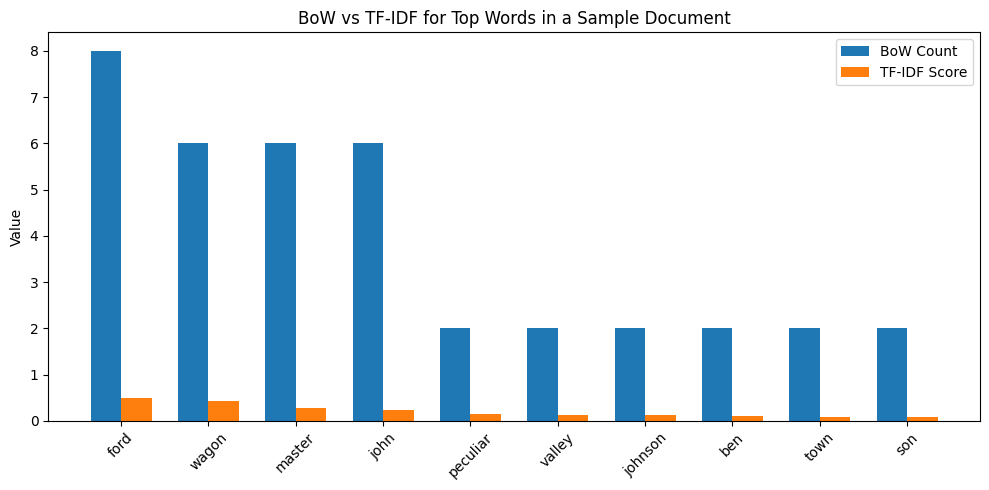

In [58]:
# Get top N words by TF-IDF score
N = 10
top_indices = tfidf_sample.argsort()[-N:][::-1]  # Indices of top N TF-IDF scores
top_words = [feature_names_stem[i] for i in top_indices]
top_bow = [bow_sample[i] for i in top_indices]
top_tfidf = [tfidf_sample[i] for i in top_indices]

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.35
x = range(N)
ax.bar([i - bar_width/2 for i in x], top_bow, bar_width, label='BoW Count', color='#1f77b4')
ax.bar([i + bar_width/2 for i in x], top_tfidf, bar_width, label='TF-IDF Score', color='#ff7f0e')
ax.set_xticks(x)
ax.set_xticklabels(top_words, rotation=45)
ax.set_ylabel('Value')
ax.set_title('BoW vs TF-IDF for Top Words in a Sample Document')
ax.legend()
plt.tight_layout()
plt.show()

In [59]:
# Get vocabularies
bow_vocab = count_vectorizer_stem.get_feature_names_out()
tfidf_vocab = tfidf_vectorizer_stem.get_feature_names_out()

print(f"BoW Vocabulary Size: {len(bow_vocab)}")
print(f"TF-IDF Vocabulary Size: {len(tfidf_vocab)}")
print(f"Common Words: {len(set(bow_vocab).intersection(tfidf_vocab))}")

BoW Vocabulary Size: 5000
TF-IDF Vocabulary Size: 5000
Common Words: 5000


In [68]:
# Feature importance analysis
def analyze_features(vectorizer, feature_matrix, labels, approach_name):
    """Analyze most important features for each class"""
    feature_names = vectorizer.get_feature_names_out()
    
    # Calculate mean feature values for each class
    pos_mask = labels == 1
    neg_mask = labels == 0
    
    pos_means = np.array(feature_matrix[pos_mask].mean(axis=0)).flatten()
    neg_means = np.array(feature_matrix[neg_mask].mean(axis=0)).flatten()
    
    # Get top features for each class
    pos_indices = pos_means.argsort()[-10:][::-1]
    neg_indices = neg_means.argsort()[-10:][::-1]
    
    print(f"\nTop features for {approach_name}:")
    print("Positive sentiment:", [feature_names[i] for i in pos_indices])
    print("Negative sentiment:", [feature_names[i] for i in neg_indices])

# Analyze features for different approaches
analyze_features(count_vectorizer_stem, X_train_count_stem, y_train, "Stemmed + Count")
analyze_features(tfidf_vectorizer_stem, X_train_tfidf_stem, y_train, "Stemmed + TF-IDF")


Top features for Stemmed + Count:
Positive sentiment: ['br', 'film', 'movi', 'one', 'like', 'time', 'see', 'good', 'stori', 'charact']
Negative sentiment: ['br', 'movi', 'film', 'one', 'like', 'make', 'bad', 'even', 'get', 'watch']

Top features for Stemmed + TF-IDF:
Positive sentiment: ['br', 'film', 'movi', 'one', 'great', 'like', 'love', 'good', 'see', 'stori']
Negative sentiment: ['movi', 'br', 'film', 'like', 'bad', 'one', 'watch', 'even', 'good', 'make']


# Models training

Let's train some models (Logistic Regression, Naive Bayes and Random Forest) on TF-IDF and BoW to get a sense of baseline performance

In [74]:
# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(random_state = 42, max_iter = 1000),
    'Random Forest': RandomForestClassifier(random_state = 42, n_estimators = 100),
    'Naive Bayes': MultinomialNB()
}

# Data combinations to compare
data_combinations = {
    'Stemmed + Count': (X_train_count_stem, X_val_count_stem),
    'Lemmatized + Count': (X_train_count_lem, X_val_count_lem),
    'Stemmed + TF-IDF': (X_train_tfidf_stem, X_val_tfidf_stem),
    'Lemmatized + TF-IDF': (X_train_tfidf_lem, X_val_tfidf_lem)
}

results = {}


==================== Stemmed + Count ====================

Training Logistic Regression...


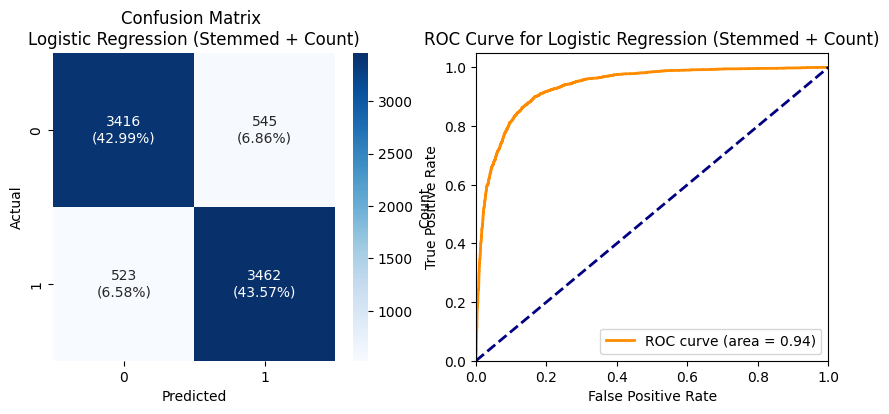


Logistic Regression (Stemmed + Count) Results:
Accuracy:  0.8656
Precision: 0.8640
Recall:    0.8688
F1-Score:  0.8664
ROC-AUC:   0.9351

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.86      3961
           1       0.86      0.87      0.87      3985

    accuracy                           0.87      7946
   macro avg       0.87      0.87      0.87      7946
weighted avg       0.87      0.87      0.87      7946


Training Random Forest...


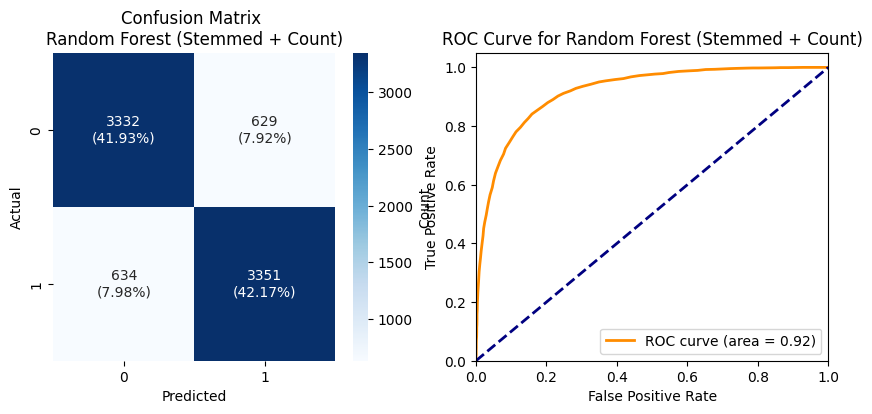


Random Forest (Stemmed + Count) Results:
Accuracy:  0.8411
Precision: 0.8420
Recall:    0.8409
F1-Score:  0.8414
ROC-AUC:   0.9185

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      3961
           1       0.84      0.84      0.84      3985

    accuracy                           0.84      7946
   macro avg       0.84      0.84      0.84      7946
weighted avg       0.84      0.84      0.84      7946


Training Naive Bayes...


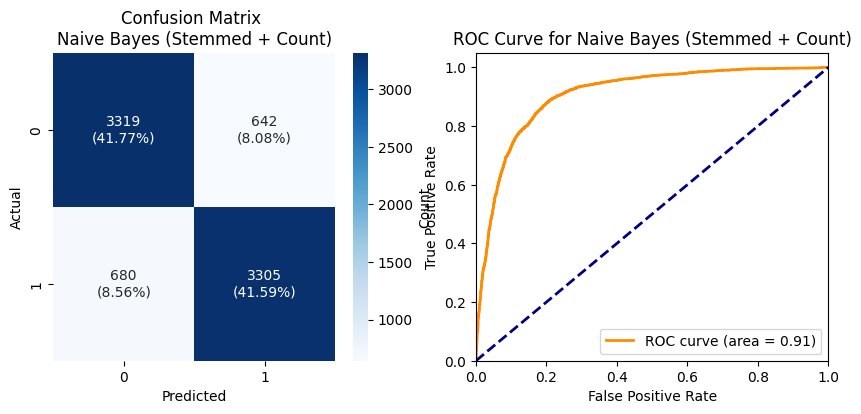


Naive Bayes (Stemmed + Count) Results:
Accuracy:  0.8336
Precision: 0.8373
Recall:    0.8294
F1-Score:  0.8333
ROC-AUC:   0.9066

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.84      0.83      3961
           1       0.84      0.83      0.83      3985

    accuracy                           0.83      7946
   macro avg       0.83      0.83      0.83      7946
weighted avg       0.83      0.83      0.83      7946


==================== Lemmatized + Count ====================

Training Logistic Regression...


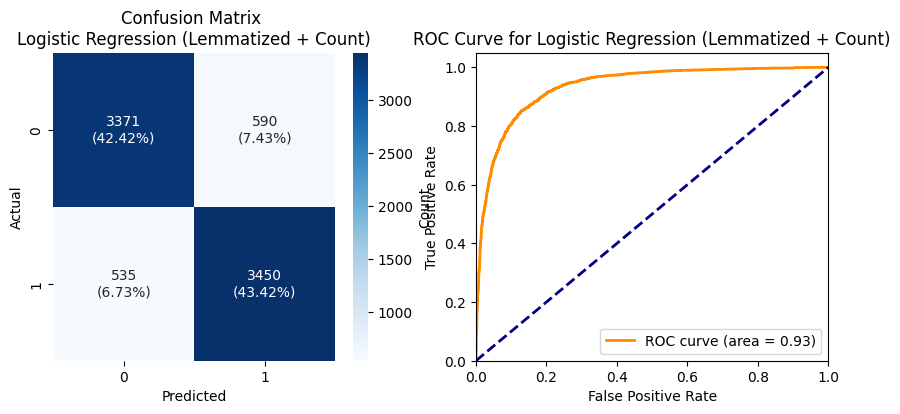


Logistic Regression (Lemmatized + Count) Results:
Accuracy:  0.8584
Precision: 0.8540
Recall:    0.8657
F1-Score:  0.8598
ROC-AUC:   0.9338

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.86      3961
           1       0.85      0.87      0.86      3985

    accuracy                           0.86      7946
   macro avg       0.86      0.86      0.86      7946
weighted avg       0.86      0.86      0.86      7946


Training Random Forest...


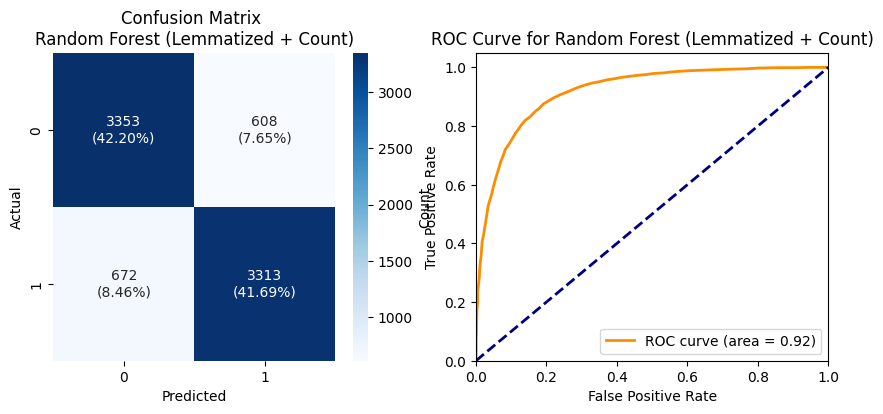


Random Forest (Lemmatized + Count) Results:
Accuracy:  0.8389
Precision: 0.8449
Recall:    0.8314
F1-Score:  0.8381
ROC-AUC:   0.9182

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.85      0.84      3961
           1       0.84      0.83      0.84      3985

    accuracy                           0.84      7946
   macro avg       0.84      0.84      0.84      7946
weighted avg       0.84      0.84      0.84      7946


Training Naive Bayes...


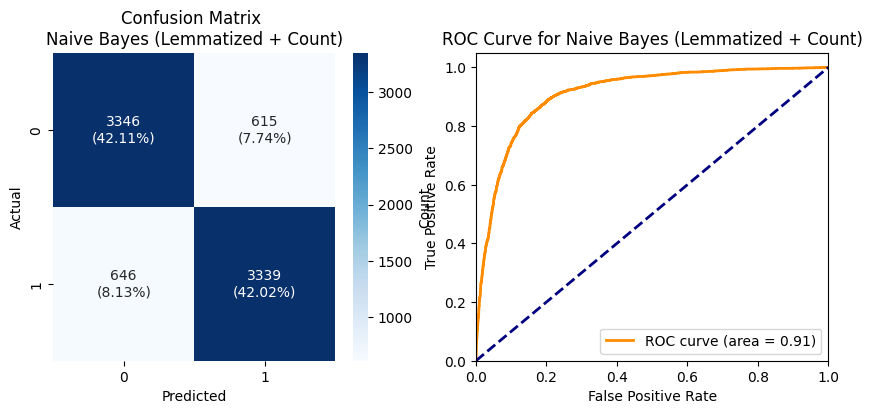


Naive Bayes (Lemmatized + Count) Results:
Accuracy:  0.8413
Precision: 0.8445
Recall:    0.8379
F1-Score:  0.8412
ROC-AUC:   0.9101

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      3961
           1       0.84      0.84      0.84      3985

    accuracy                           0.84      7946
   macro avg       0.84      0.84      0.84      7946
weighted avg       0.84      0.84      0.84      7946


==================== Stemmed + TF-IDF ====================

Training Logistic Regression...


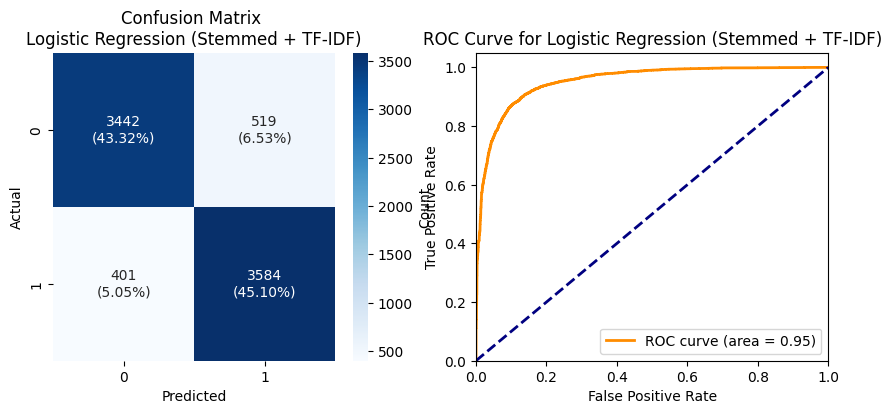


Logistic Regression (Stemmed + TF-IDF) Results:
Accuracy:  0.8842
Precision: 0.8735
Recall:    0.8994
F1-Score:  0.8863
ROC-AUC:   0.9517

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88      3961
           1       0.87      0.90      0.89      3985

    accuracy                           0.88      7946
   macro avg       0.88      0.88      0.88      7946
weighted avg       0.88      0.88      0.88      7946


Training Random Forest...


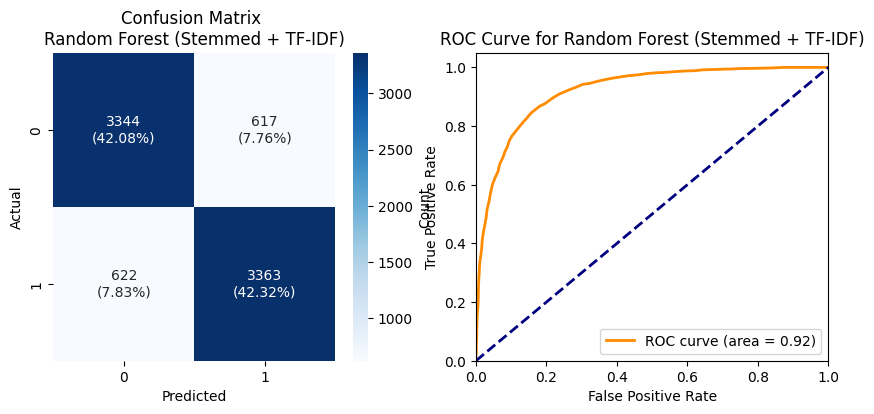


Random Forest (Stemmed + TF-IDF) Results:
Accuracy:  0.8441
Precision: 0.8450
Recall:    0.8439
F1-Score:  0.8444
ROC-AUC:   0.9200

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      3961
           1       0.84      0.84      0.84      3985

    accuracy                           0.84      7946
   macro avg       0.84      0.84      0.84      7946
weighted avg       0.84      0.84      0.84      7946


Training Naive Bayes...


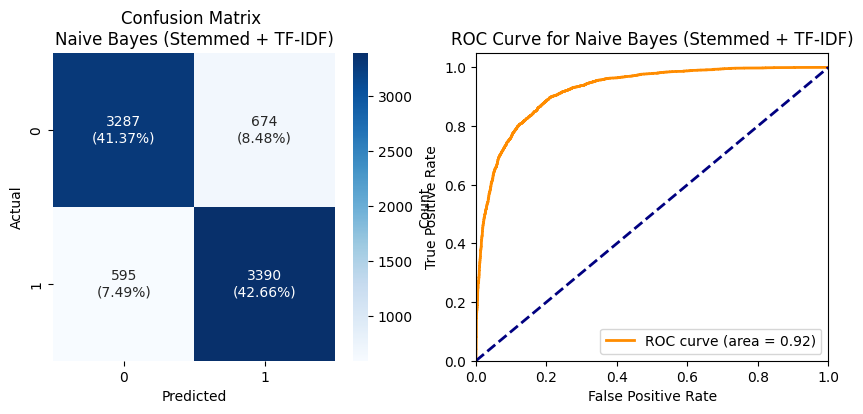


Naive Bayes (Stemmed + TF-IDF) Results:
Accuracy:  0.8403
Precision: 0.8342
Recall:    0.8507
F1-Score:  0.8423
ROC-AUC:   0.9229

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84      3961
           1       0.83      0.85      0.84      3985

    accuracy                           0.84      7946
   macro avg       0.84      0.84      0.84      7946
weighted avg       0.84      0.84      0.84      7946


==================== Lemmatized + TF-IDF ====================

Training Logistic Regression...


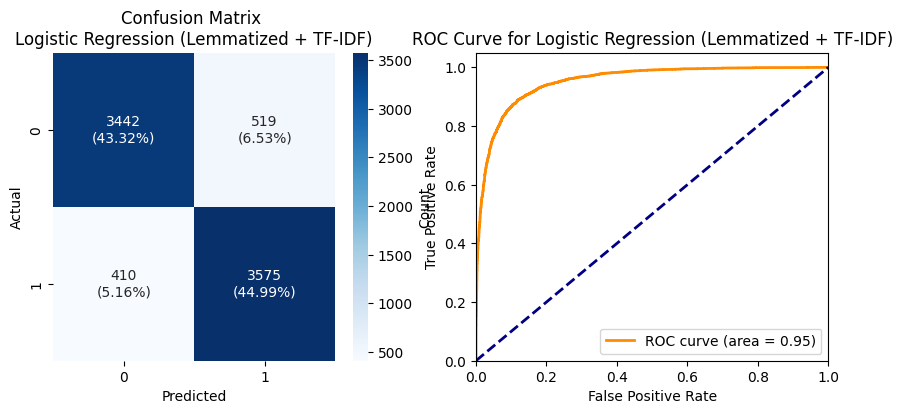


Logistic Regression (Lemmatized + TF-IDF) Results:
Accuracy:  0.8831
Precision: 0.8732
Recall:    0.8971
F1-Score:  0.8850
ROC-AUC:   0.9519

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      3961
           1       0.87      0.90      0.89      3985

    accuracy                           0.88      7946
   macro avg       0.88      0.88      0.88      7946
weighted avg       0.88      0.88      0.88      7946


Training Random Forest...


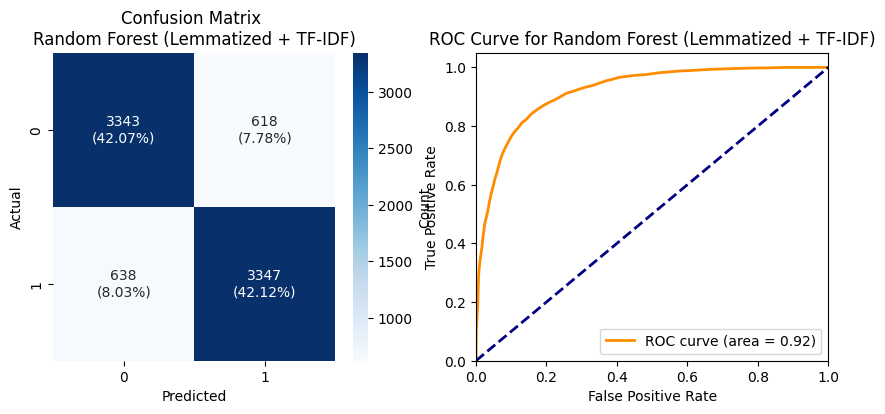


Random Forest (Lemmatized + TF-IDF) Results:
Accuracy:  0.8419
Precision: 0.8441
Recall:    0.8399
F1-Score:  0.8420
ROC-AUC:   0.9185

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      3961
           1       0.84      0.84      0.84      3985

    accuracy                           0.84      7946
   macro avg       0.84      0.84      0.84      7946
weighted avg       0.84      0.84      0.84      7946


Training Naive Bayes...


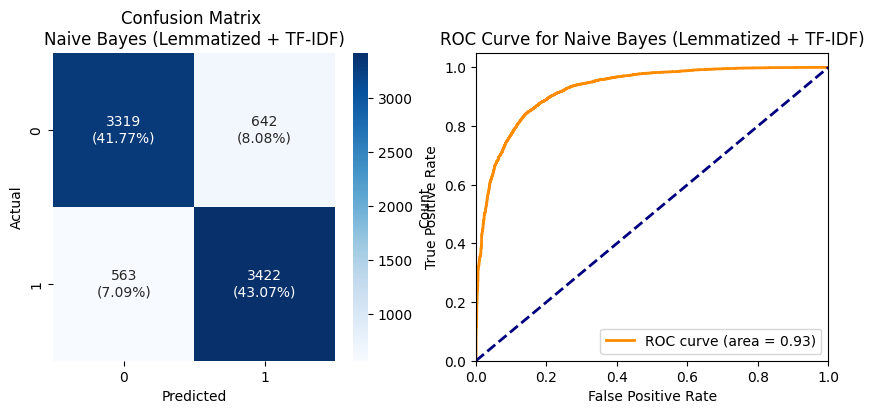


Naive Bayes (Lemmatized + TF-IDF) Results:
Accuracy:  0.8484
Precision: 0.8420
Recall:    0.8587
F1-Score:  0.8503
ROC-AUC:   0.9263

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.85      3961
           1       0.84      0.86      0.85      3985

    accuracy                           0.85      7946
   macro avg       0.85      0.85      0.85      7946
weighted avg       0.85      0.85      0.85      7946



In [ ]:
# Test each model with each data configuration
for config_name, (X_train_data, X_val_data) in data_combinations.items():
    print(f"\n{'='*20} {config_name} {'='*20}")
    
    config_results = {}
    
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        
        # Train model
        model.fit(X_train_data, y_train)
        
        # Evaluate model
        metrics = evaluate_cls_model(model, X_val_data, y_val, f"{model_name} ({config_name})", return_metrics = True)
        
        config_results[model_name] = metrics
    
    results[config_name] = config_results

In [79]:
comparison_data = []
for config in results:
    for model in results[config]:
        metrics = results[config][model]
        comparison_data.append({
            'Configuration': config,
            'Model': model,
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1'],
            'ROC-AUC': metrics['roc_auc'] if metrics['roc_auc'] is not None else 'N/A'
        })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(3)
comparison_df = comparison_df.sort_values(by='F1-Score', ascending=False)

print("\nComplete Results Summary:")
comparison_df


Complete Results Summary:


,Configuration,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
6,Stemmed + TF-IDF,Logistic Regression,0.884,0.874,0.899,0.886,0.952
9,Lemmatized + TF-IDF,Logistic Regression,0.883,0.873,0.897,0.885,0.952
0,Stemmed + Count,Logistic Regression,0.866,0.864,0.869,0.866,0.935
3,Lemmatized + Count,Logistic Regression,0.858,0.854,0.866,0.860,0.934
11,Lemmatized + TF-IDF,Naive Bayes,0.848,0.842,0.859,0.850,0.926
7,Stemmed + TF-IDF,Random Forest,0.844,0.845,0.844,0.844,0.920
8,Stemmed + TF-IDF,Naive Bayes,0.840,0.834,0.851,0.842,0.923
10,Lemmatized + TF-IDF,Random Forest,0.842,0.844,0.840,0.842,0.919
1,Stemmed + Count,Random Forest,0.841,0.842,0.841,0.841,0.919
5,Lemmatized + Count,Naive Bayes,0.841,0.844,0.838,0.841,0.910


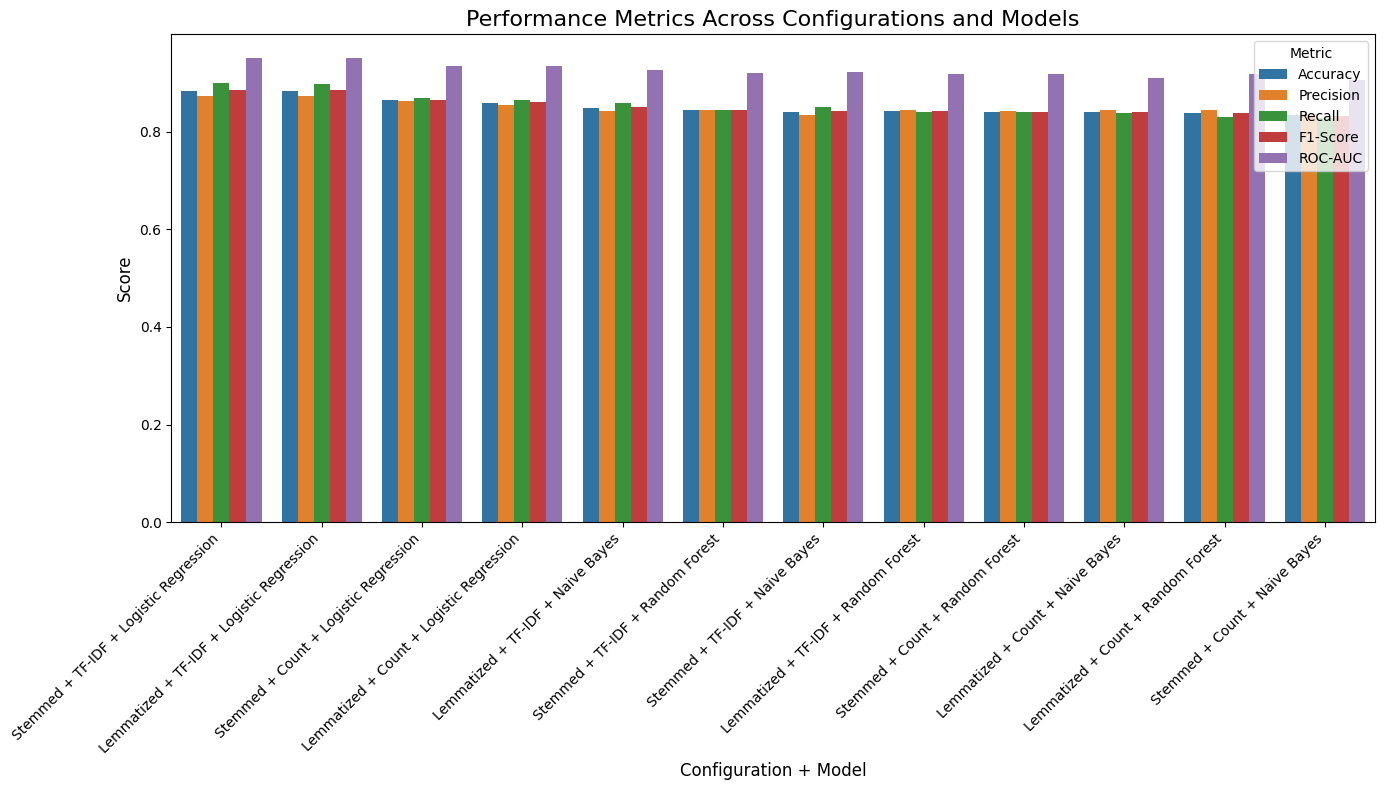

In [84]:
df_plot = comparison_df.copy()
df_plot['Config_Model'] = df_plot['Configuration'] + ' + ' + df_plot['Model']
df_melted = pd.melt(df_plot, 
                    id_vars=['Config_Model'], 
                    value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
                    var_name='Metric', 
                    value_name='Score')

# Plot 1: Grouped Bar Plot
plt.figure(figsize=(14, 8))
bar_plot = sns.barplot(x='Config_Model', y='Score', hue='Metric', data=df_melted)
plt.title('Performance Metrics Across Configurations and Models', fontsize=16)
plt.xlabel('Configuration + Model', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric', loc='upper right')
plt.tight_layout()




**Best models**:
- Logistic Regression: Stemmed + TF-IDF (F1-Score: 0.886, ROC-AUC: 0.952)
- Naive Bayes: Lemmatized + TF-IDF (F1-Score: 0.85, ROC-AUC: 0.926)
- Random Forest: Stemmed + TF-IDF (F1-Score: 0.844, ROC-AUC: 0.92)

## Hyperparameters tuning

In [98]:
# Hyperparameter grids
param_grids = {
    'Logistic Regression': [
        {'solver': ['liblinear'], 'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
        {'solver': ['lbfgs'], 'C': [0.1, 1, 10, 100], 'penalty': ['l2']}
    ],
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Naive Bayes': {
        'alpha': [0.1, 0.5, 1.0, 2.0]
    }
}

best_models_combs = {
    'Logistic Regression' : 'Stemmed + TF-IDF',
    'Random Forest'       : 'Lemmatized + TF-IDF',
    'Naive Bayes'         : 'Stemmed + TF-IDF'
}

In [99]:
# Perform hyperparameter tuning
tuned_models = {}

for model_name, config in best_models_combs.items():
    print(f"\nTuning {model_name}...")

    X_train, X_val = data_combinations[config]

    # Initialize model
    if model_name == 'Logistic Regression':
        model = LogisticRegression(random_state = 42)
    elif model_name == 'Random Forest':
        model = RandomForestClassifier(random_state = 42)
    elif model_name == 'Naive Bayes':
        model = MultinomialNB()

    random_search = RandomizedSearchCV(model, param_grids[model_name], scoring = 'f1', cv = 5, verbose = 0, n_jobs = -1)

    random_search.fit(X_train, y_train)

    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best CV score: {random_search.best_score_:.4f}")
    
    tuned_models[model_name] = {
        'model': random_search.best_estimator_,
        'params': random_search.best_params_,
        'cv_score': random_search.best_score_
    }


Tuning Logistic Regression...
Best parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 1}
Best CV score: 0.8824

Tuning Random Forest...
Best parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': None}
Best CV score: 0.8450

Tuning Naive Bayes...


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters: {'alpha': 2.0}
Best CV score: 0.8470


In [100]:
tuned_models

{'Logistic Regression': {'model': LogisticRegression(C=1, random_state=42, solver='liblinear'),
  'params': {'solver': 'liblinear', 'penalty': 'l2', 'C': 1},
  'cv_score': 0.8823877313499462},
 'Random Forest': {'model': RandomForestClassifier(min_samples_leaf=4, min_samples_split=10,
                         n_estimators=200, random_state=42),
  'params': {'n_estimators': 200,
   'min_samples_split': 10,
   'min_samples_leaf': 4,
   'max_depth': None},
  'cv_score': 0.8450476122399191},
 'Naive Bayes': {'model': MultinomialNB(alpha=2.0),
  'params': {'alpha': 2.0},
  'cv_score': 0.8470157300117235}}


==================== Evaluating tuned Logistic Regression ====================


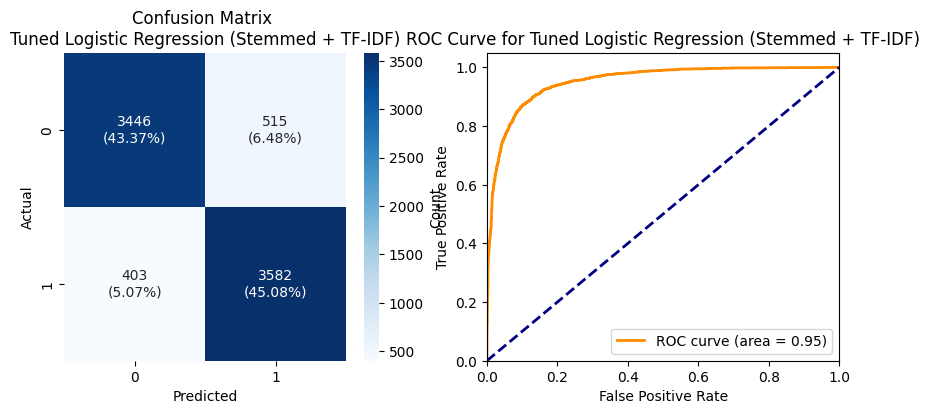


Tuned Logistic Regression (Stemmed + TF-IDF) Results:
Accuracy:  0.8845
Precision: 0.8743
Recall:    0.8989
F1-Score:  0.8864
ROC-AUC:   0.9517

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88      3961
           1       0.87      0.90      0.89      3985

    accuracy                           0.88      7946
   macro avg       0.88      0.88      0.88      7946
weighted avg       0.88      0.88      0.88      7946


==================== Evaluating tuned Random Forest ====================


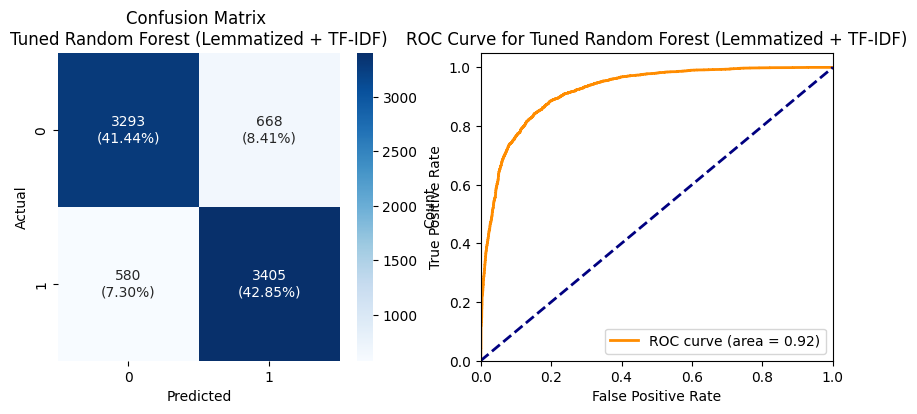


Tuned Random Forest (Lemmatized + TF-IDF) Results:
Accuracy:  0.8429
Precision: 0.8360
Recall:    0.8545
F1-Score:  0.8451
ROC-AUC:   0.9212

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84      3961
           1       0.84      0.85      0.85      3985

    accuracy                           0.84      7946
   macro avg       0.84      0.84      0.84      7946
weighted avg       0.84      0.84      0.84      7946


==================== Evaluating tuned Naive Bayes ====================


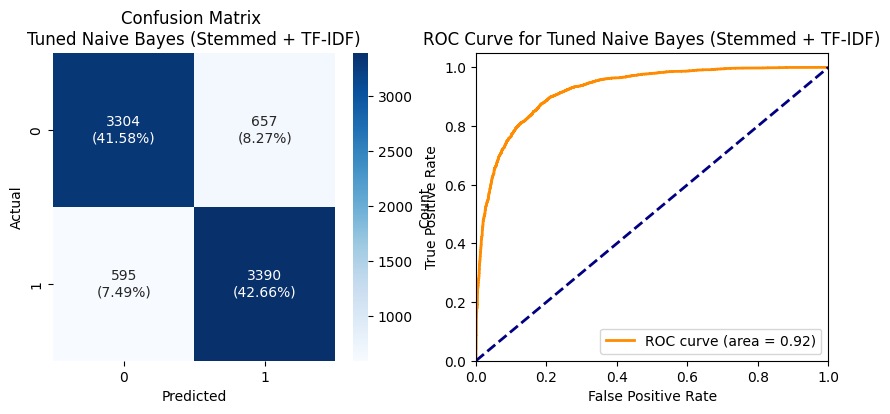


Tuned Naive Bayes (Stemmed + TF-IDF) Results:
Accuracy:  0.8424
Precision: 0.8377
Recall:    0.8507
F1-Score:  0.8441
ROC-AUC:   0.9236

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84      3961
           1       0.84      0.85      0.84      3985

    accuracy                           0.84      7946
   macro avg       0.84      0.84      0.84      7946
weighted avg       0.84      0.84      0.84      7946



In [116]:
config_results = {}

for model_name, model_info in tuned_models.items():
    print(f"\n{'='*20} Evaluating tuned {model_name} {'='*20}")
    
    # Get data configuration
    config = best_models_combs[model_name]
    X_train, X_val = data_combinations[config]
    
    # Evaluate model
    metrics = evaluate_cls_model(model_info['model'], X_val, y_val, f"Tuned {model_name} ({config})", return_metrics = True)
        
    config_results[model_name] = metrics

In [117]:
config_results

{'Logistic Regression': {'accuracy': 0.884470173672288,
  'precision': 0.8742982670246522,
  'recall': 0.898870765370138,
  'f1': 0.8864142538975501,
  'roc_auc': 0.9517119392115789},
 'Random Forest': {'accuracy': 0.8429398439466398,
  'precision': 0.8359931254603487,
  'recall': 0.8544542032622334,
  'f1': 0.8451228592702904,
  'roc_auc': 0.921229414647265},
 'Naive Bayes': {'accuracy': 0.8424364460105713,
  'precision': 0.83765752409192,
  'recall': 0.8506900878293601,
  'f1': 0.8441235059760956,
  'roc_auc': 0.9236119289800777}}

In [119]:
# Initialize comparison data
comparison_data = []
for model_name in config_results:
    metrics = config_results[model_name]
    comparison_data.append({
        'Model': model_name,
        'Configuration': best_models_combs[model_name],
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1'],
        'ROC-AUC': metrics['roc_auc'] if metrics['roc_auc'] is not None else 'N/A'
    })

# Create and sort DataFrame
tuned_comparison_df = pd.DataFrame(comparison_data)
tuned_comparison_df = tuned_comparison_df.round(3)
tuned_comparison_df = tuned_comparison_df.sort_values(by='F1-Score', ascending=False)

print("\nComplete Results Summary:")
tuned_comparison_df


Complete Results Summary:


,Model,Configuration,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,Stemmed + TF-IDF,0.884,0.874,0.899,0.886,0.952
1,Random Forest,Lemmatized + TF-IDF,0.843,0.836,0.854,0.845,0.921
2,Naive Bayes,Stemmed + TF-IDF,0.842,0.838,0.851,0.844,0.924


# Bert

In this section, we'll explore a custom model built on top of the pre-trained BERT model. The custom model consists of the BERT model followed by a classification layer, which enables the model to make predictions for our specific classification task.

Pre-trained BERT Model: The base BERT model is used to extract contextual embeddings from the input text. BERT is trained to capture relationships between words in a sentence.

Classification Layer: After BERT generates embeddings for the input text, the output is passed through a classification layer. The purpose of the classification layer is to take the representations from BERT and map them to predictions.

By using this custom model, we take advantage of BERT's rich language understanding and adapt it specifically for our classification problem.